In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
from datasets import load_dataset
import torch.multiprocessing
import os
from torch import nn

print('DEFAULT:', torch.get_num_threads(), torch.get_num_interop_threads())
# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# torch.set_num_threads(1), torch.set_num_interop_threads(1)
print(torch.get_num_threads(), torch.get_num_interop_threads())
print(torch.__config__.parallel_info())

DEFAULT: 4 4
4 4
ATen/Parallel:
	at::get_num_threads() : 4
	at::get_num_interop_threads() : 4
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 4
Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 4
Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
std::thread::hardware_concurrency() : 8
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



In [2]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
model.eval()
transforms = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.transforms

In [4]:
with open('../imagenet1000.txt', 'r') as fopen:
    lines = fopen.readlines()

def process_classes(line: str):
    splitted = line.strip().removeprefix('{').removesuffix(',').split(':')
    return (int(splitted[0]), splitted[1].strip().strip('\''))

orig_classes = dict(map(process_classes, lines))

imagenette_classes = dict(enumerate(['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']))

for k, v in imagenette_classes.items():
    for k1, v1 in orig_classes.items():
        if v in v1:
            imagenette_classes[k] = k1

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datasource, transforms: callable):
        super().__init__()
        self.transforms = transforms
        self.datasource = datasource

    def __len__(self) -> int:
        return len(self.datasource)

    def __getitem__(self, index: int) -> torch.Tensor:
        data = self.datasource[index]
        image, label = data['image'], data['label']
        if image.mode != 'RGB':
            image = Image.fromarray(np.array(image)[..., None].repeat(3, -1))
        return self.transforms(image), imagenette_classes[label]

In [6]:
imagenette_train = load_dataset('frgfm/imagenette', '320px', split='train')
imagenette_valid = load_dataset('frgfm/imagenette', '320px', split='validation')

In [7]:
num_workers = 4
batch_size = 1

In [8]:
tf = transforms()
trainset = Dataset(datasource=imagenette_train, transforms=tf)
validset = Dataset(datasource=imagenette_valid, transforms=tf)
valid_dataloader = torch.utils.data.DataLoader(validset, num_workers=num_workers, batch_size=batch_size, shuffle=False)

In [9]:
def nbytes(model: torch.nn.Module):
    n = 0
    for p in model.parameters():
        n += p.nbytes
    return n / 1024 ** 2

In [10]:
from torch.profiler import profile, record_function, ProfilerActivity
from itertools import product
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
from torch.ao.quantization import get_default_qconfig_mapping, get_default_qconfig
from torch.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping
import gc
from contextlib import nullcontext
from timeit import timeit
import time
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import datetime
# import torch.quantization._numeric_suite as ns
import torch.quantization._numeric_suite_fx as ns

def fix_seed(worker_id=0, seed=0xBADCAFE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed()

torch_generator = torch.Generator()
torch_generator.manual_seed(0xBADCAFFE)

In [11]:
from tqdm.notebook import tqdm
from copy import deepcopy

In [15]:
copy_model = deepcopy(model)
module_a = deepcopy(model)
module_a.heads.head = nn.Identity()
module_b = model.heads.head
# model = LoggerModule(module_a, module_b)

In [16]:
qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping().set_global(qconfig)
# prepared_model = torch.ao.quantization.prepare(model).eval()
example_inputs_a = next(iter(valid_dataloader))[0]
example_inputs_b = torch.randn(1, 512)
prepared_module_a = prepare_fx(module_a, qconfig_mapping, example_inputs_a)
prepared_module_b = prepare_fx(module_b, qconfig_mapping, example_inputs_b)

with torch.inference_mode():
    for x, _ in tqdm(valid_dataloader):
        y = prepared_module_a(x)
        prepared_module_b(y)


/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/alexey/.local/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/alexey/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


  0%|          | 0/3925 [00:00<?, ?it/s]

qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping().set_global(qconfig)
prepared_model = torch.ao.quantization.prepare(model).eval()
example_inputs = next(iter(valid_dataloader))[0]
prepared_model = prepare_fx(model, qconfig_mapping, example_inputs)


with torch.inference_mode():
    for x, y in tqdm(valid_dataloader):
        prepared_model(x)


quantized_model = convert_fx(prepared_model) 

gt = []
pred = []
Y = []
with torch.inference_mode():
    for x, y in tqdm(valid_dataloader):
        y_hat = quantized_model(x)
        Y.append(y_hat)
        gt.append(y)
        pred.append(y_hat.argmax(-1))
    gt = torch.cat(gt).ravel().numpy()
    pred = torch.cat(pred).ravel().numpy()

In [17]:
quantized_a = convert_fx(prepared_module_a) 
quantized_b = convert_fx(prepared_module_b) 

/home/alexey/.local/lib/python3.10/site-packages/torch/fx/graph.py:1377: UserWarning: Node _packed_weight_0 target _packed_weight_0 _packed_weight_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '


In [18]:
gt = []
pred = []
embeddings = []
Y = []
with torch.inference_mode():
    for x, y in tqdm(valid_dataloader):
        emb = quantized_a(x)
        embeddings.append(emb)
        y_hat = quantized_b(emb)
        Y.append(y_hat)
        gt.append(y)
        pred.append(y_hat.argmax(-1))
    gt = torch.cat(gt).ravel().numpy()
    pred = torch.cat(pred).ravel().numpy()

  0%|          | 0/3925 [00:00<?, ?it/s]

In [43]:
accuracy_score(gt, pred)

0.1278980891719745

In [19]:
weight_comparison_a = ns.extract_weights('float', module_a, 'quant', quantized_a)
ns.extend_logger_results_with_comparison(weight_comparison_a, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr, 'sqnr')

In [20]:
from matplotlib import pyplot as plt

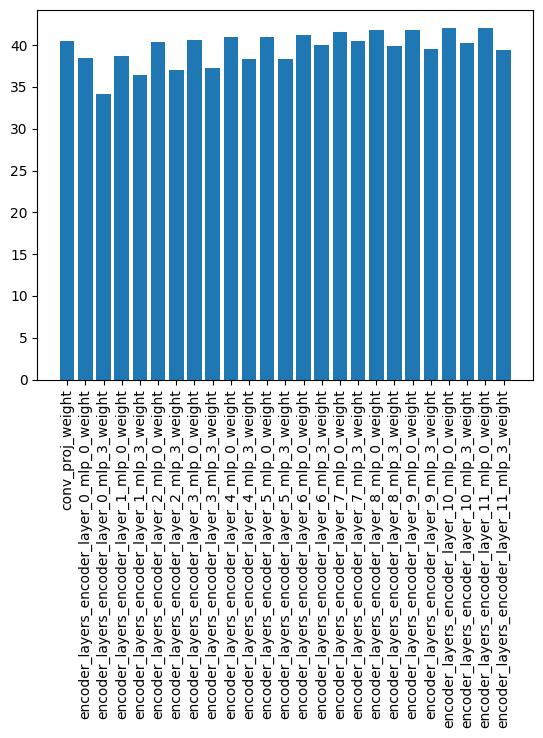

In [21]:
layers = []
sqnrs = []
for layer, layer_info in weight_comparison_a.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += v['sqnr'][0]
        sqnrs[-1] /= len(value['quant'])
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

In [22]:
weight_comparison_b = ns.extract_weights('float', module_b, 'quant', quantized_b)
ns.extend_logger_results_with_comparison(weight_comparison_b, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr, 'sqnr')

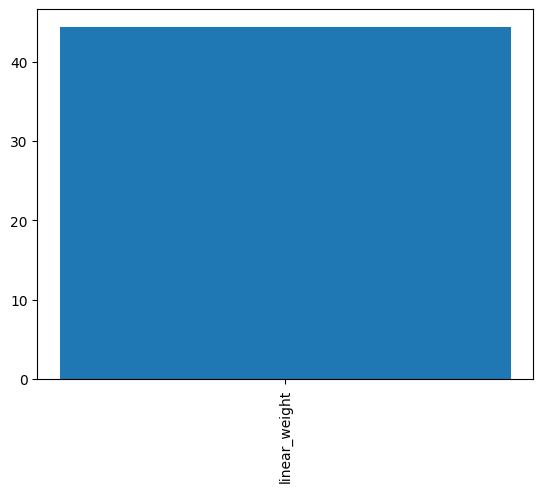

In [24]:
layers = []
sqnrs = []
for layer, layer_info in weight_comparison_b.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += v['sqnr'][0]
        sqnrs[-1] /= len(value['quant'])
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

In [26]:
indexes = np.random.randint(0, len(validset), 16)

In [27]:
qlog_a, log_a,  = ns.add_loggers(
    'float', deepcopy(module_a),
    'quant', deepcopy(quantized_a), 
    ns.OutputLogger)

# send an example datum to capture intermediate activations
with torch.inference_mode():
    for i in tqdm(indexes):
        i = int(i)
        x = validset[i][0][None]
        qlog_a(x)
        log_a(x)


# extract intermediate activations
act_comparison_a = ns.extract_logger_info(log_a, qlog_a, ns.OutputLogger, 'quant')

# add SQNR for each comparison, inplace
ns.extend_logger_results_with_comparison(act_comparison_a, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr,'sqnr')

  0%|          | 0/16 [00:00<?, ?it/s]

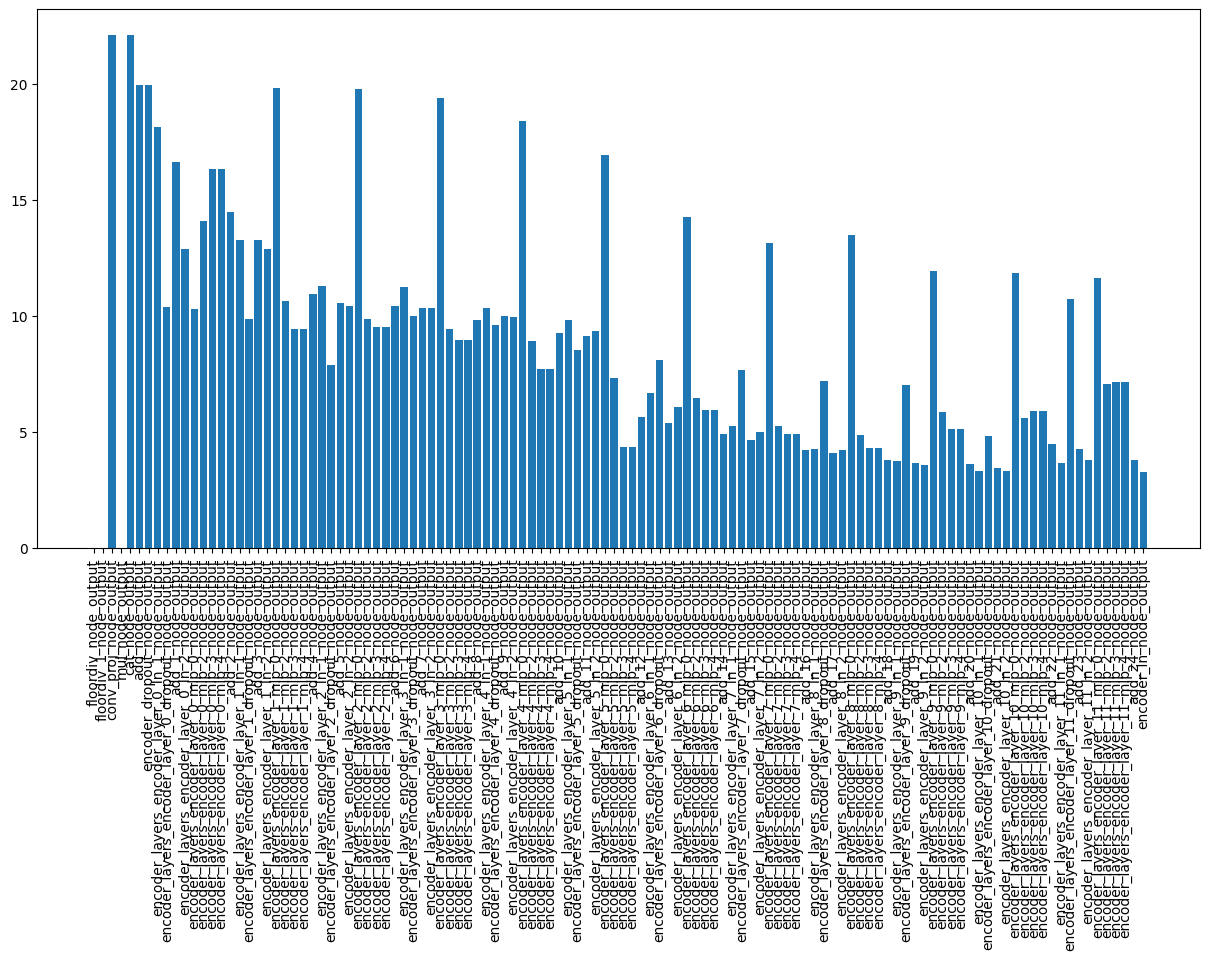

In [38]:
layers = []
sqnrs = []
for layer, layer_info in act_comparison_a.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += sum(v['sqnr']) / len(v['sqnr']) if v['sqnr'] else 0.0
        sqnrs[-1] /= len(value['quant'])
weight_comparison_b
plt.figure(figsize=(15, 7))
plt.bar(layers, sqnrs)
plt.xticks(rotation=90, size=10)
plt.show()

In [31]:
log_b, qlog_b,  = ns.add_loggers(
    'float', deepcopy(module_b),
    'quant', deepcopy(quantized_b), 
    ns.OutputLogger)

# send an example datum to capture intermediate activations
with torch.inference_mode():
    for i in tqdm(indexes):
        i = int(i)
        x = validset[i][0][None]
        qy = quantized_a(x)
        y = module_a(x)
        qlog_b(qy)
        log_b(y)


# extract intermediate activations
act_comparison_b = ns.extract_logger_info(log_b, qlog_b, ns.OutputLogger, 'quant')

# add SQNR for each comparison, inplace
ns.extend_logger_results_with_comparison(act_comparison_b, 'float', 'quant', torch.ao.ns.fx.utils.compute_sqnr,'sqnr')


  0%|          | 0/16 [00:00<?, ?it/s]

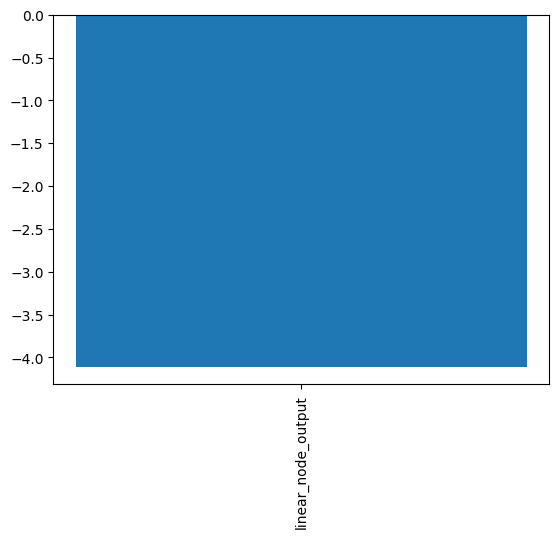

In [32]:
layers = []
sqnrs = []
for layer, layer_info in act_comparison_b.items():
    for key, value in layer_info.items():
        layers.append(f'{layer}_{key}')
        sqnrs.append(0.0)
        for v in value['quant']:
            sqnrs[-1] += sum(v['sqnr']) / len(v['sqnr'])
        sqnrs[-1] /= len(value['quant'])
weight_comparison_b
plt.bar(layers, sqnrs)
plt.xticks(rotation=90)
plt.show()

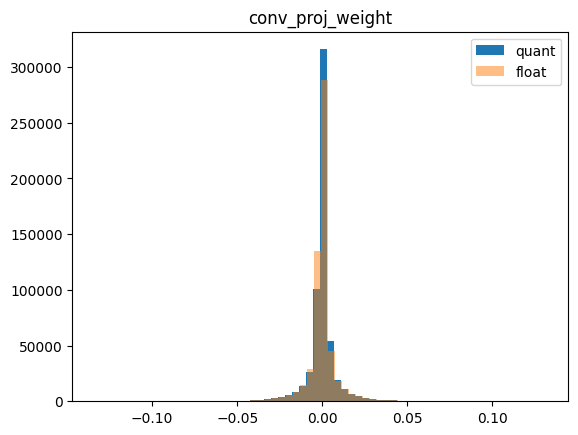

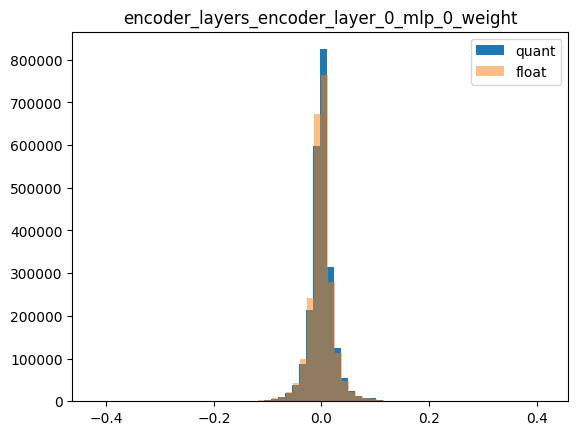

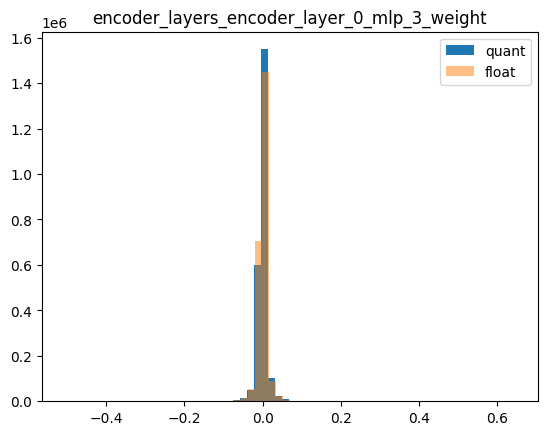

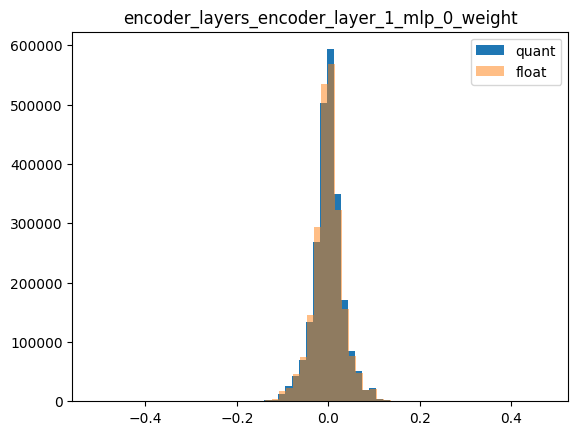

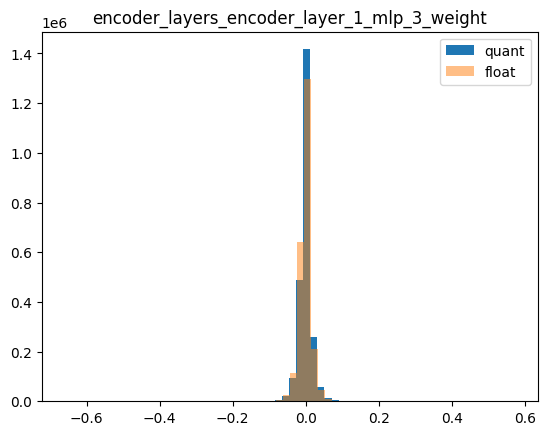

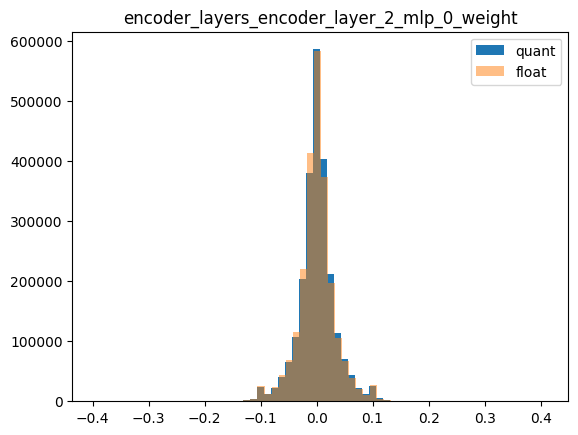

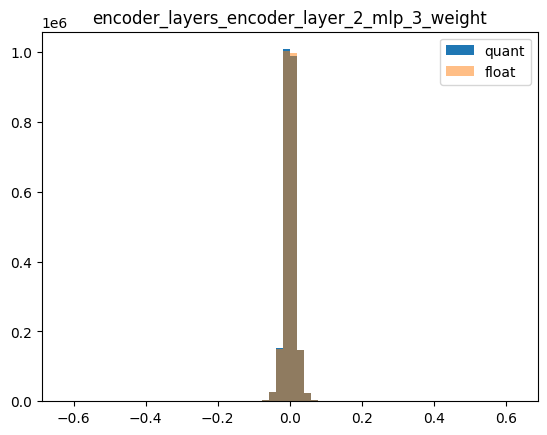

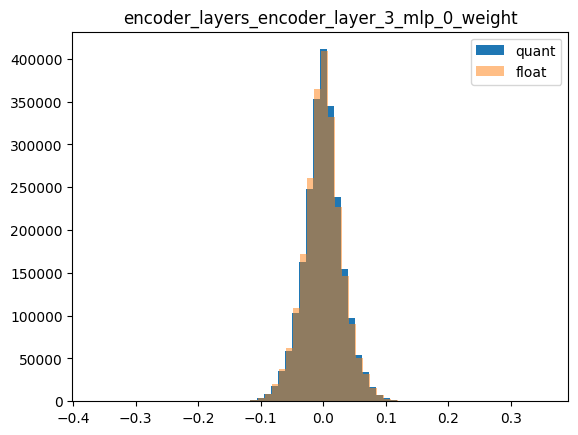

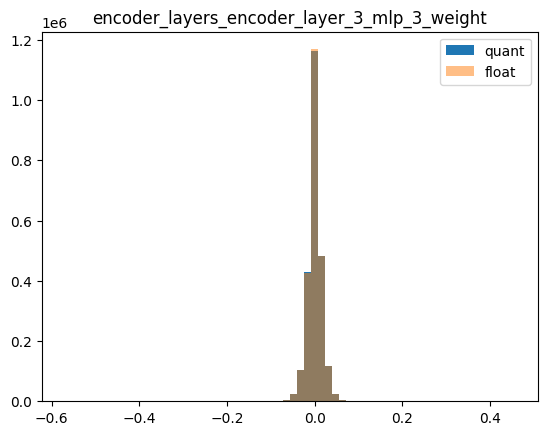

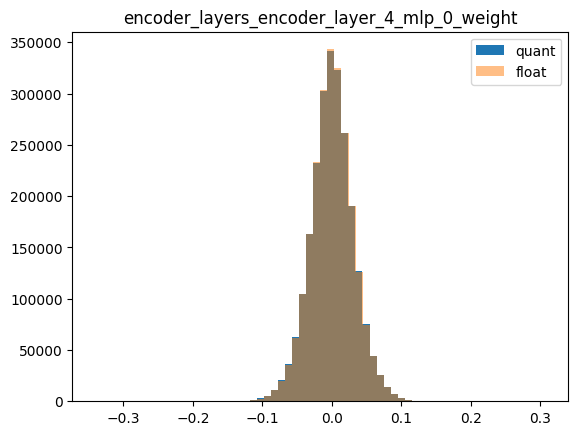

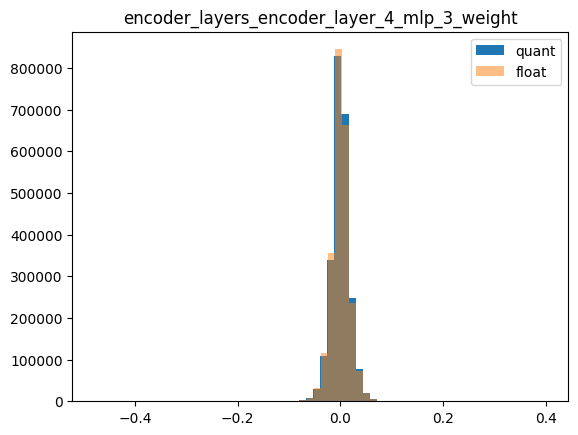

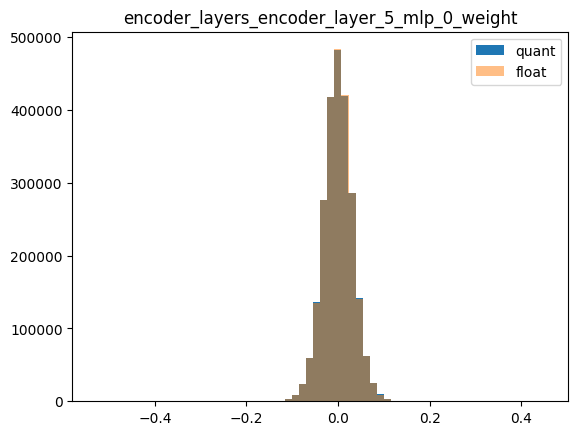

In [50]:
for layer, layer_info in weight_comparison_a.items():
    for key, value in layer_info.items():
        for q, f in zip(value['quant'], value['float']):
            if 'values' in q:
                for qv in q['values']:
                    plt.hist(qv.dequantize().ravel(), bins=64, label='quant')
            if 'values' in f:
                for fv in f['values']:
                    plt.hist(fv.ravel(), bins=64, alpha=0.5, label='float')
            plt.title(layer + '_' + key)
            plt.legend()
            plt.show()

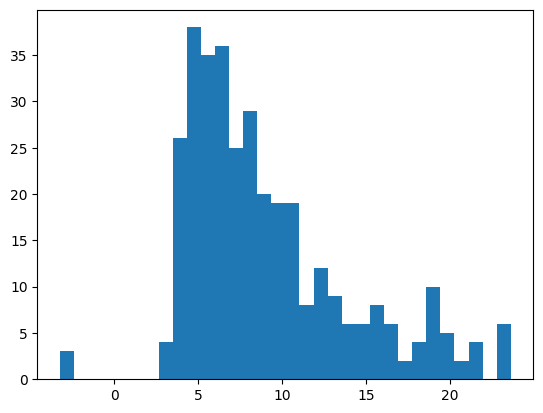

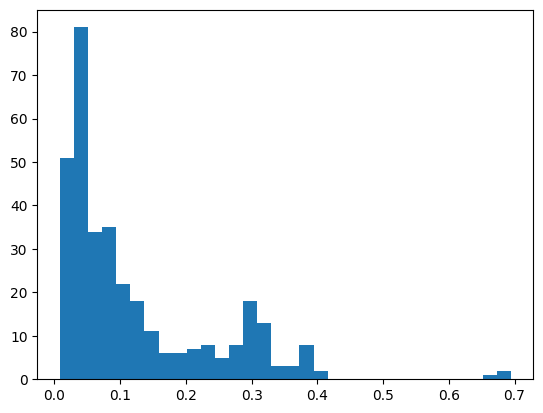

In [91]:
plt.hist(results, bins=32)
plt.show()
plt.hist(dist, bins=32)
plt.show()

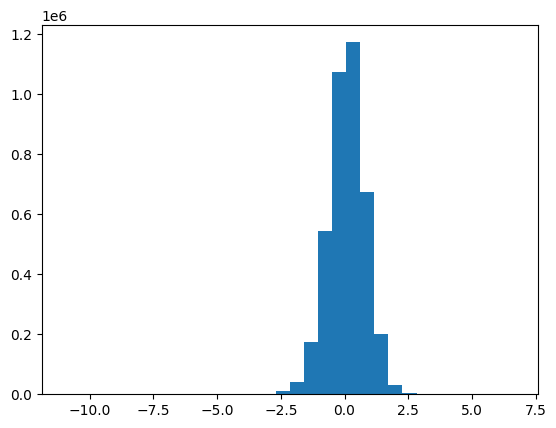

In [ ]:
plt.hist(torch.cat(Y).ravel().numpy(), bins=32, alpha=0.5)
# plt.hist(torch.cat(Y).ravel().numpy(), bins=32, alpha=0.5)
plt.show()

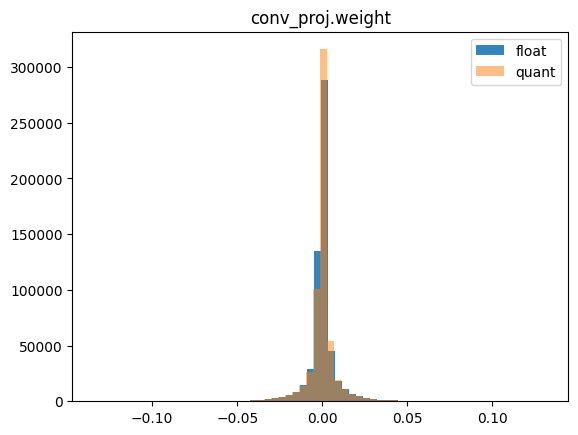

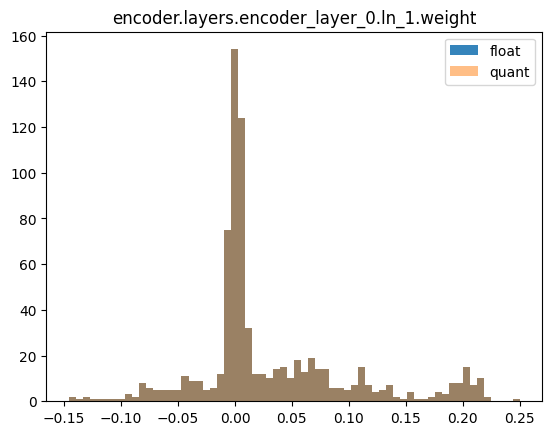

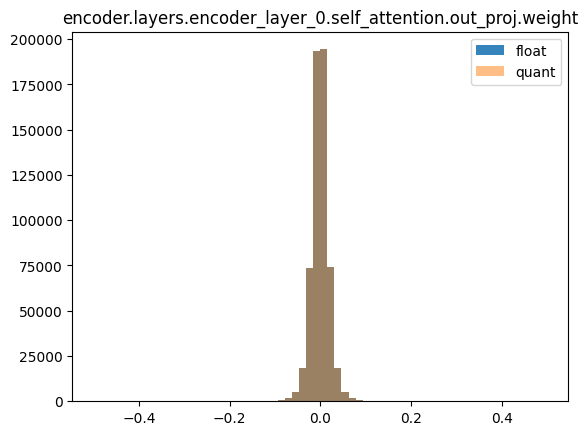

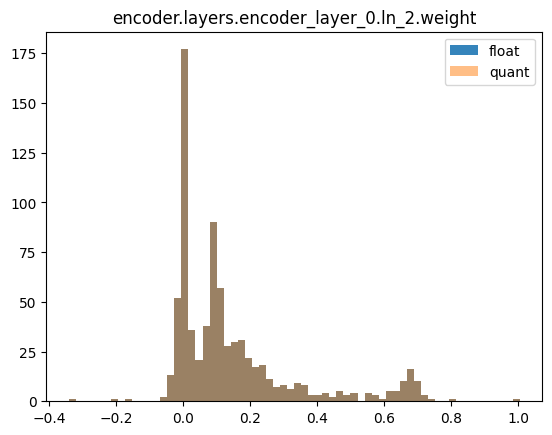

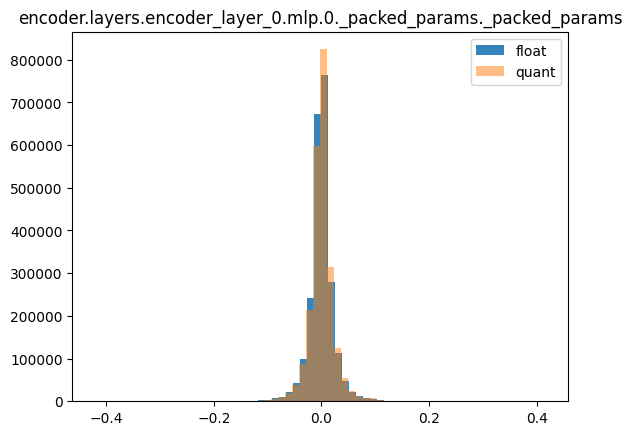

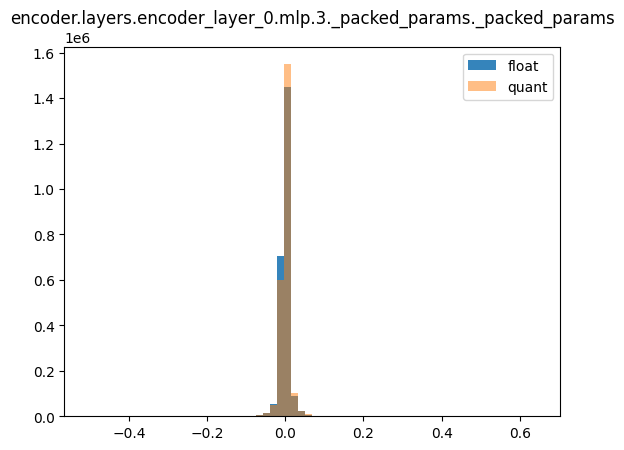

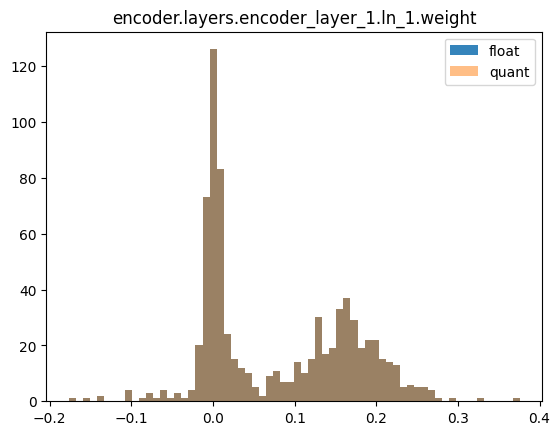

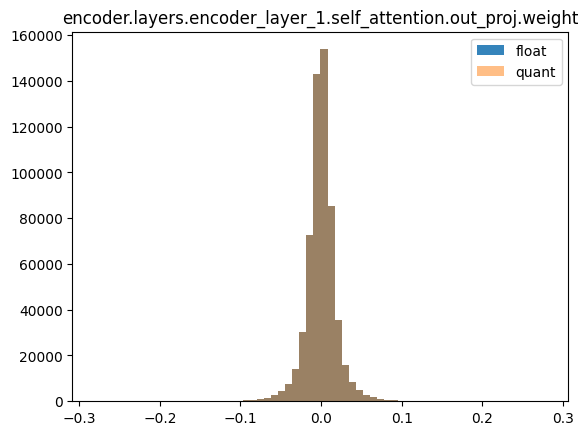

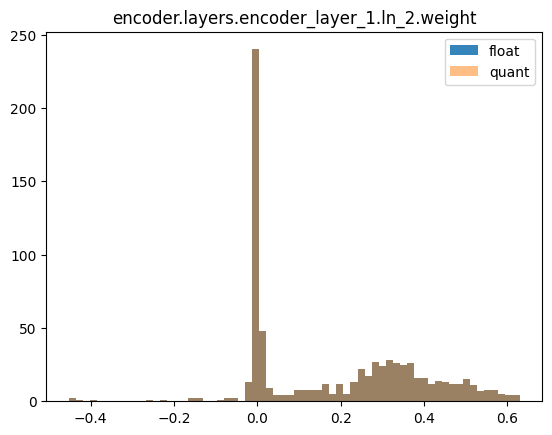

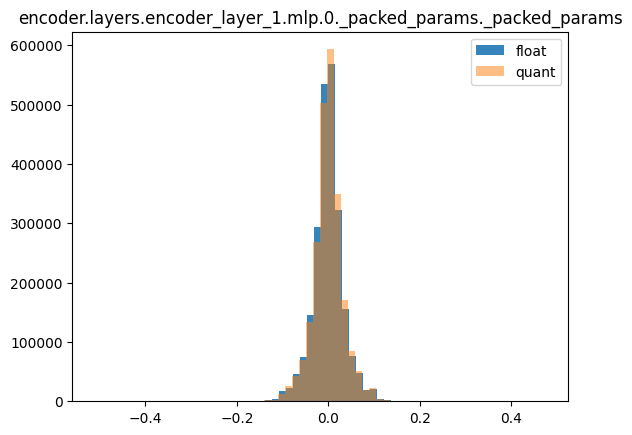

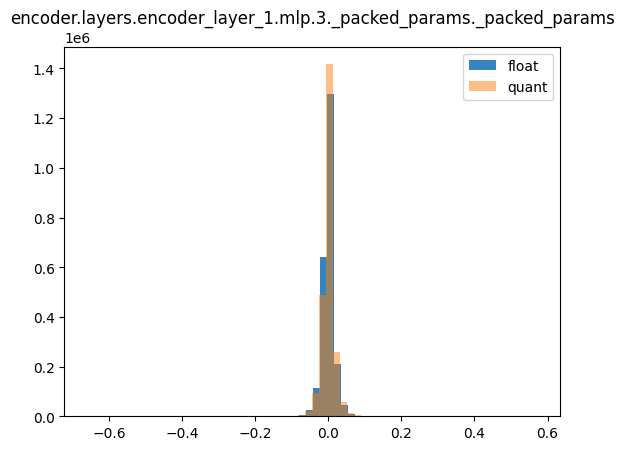

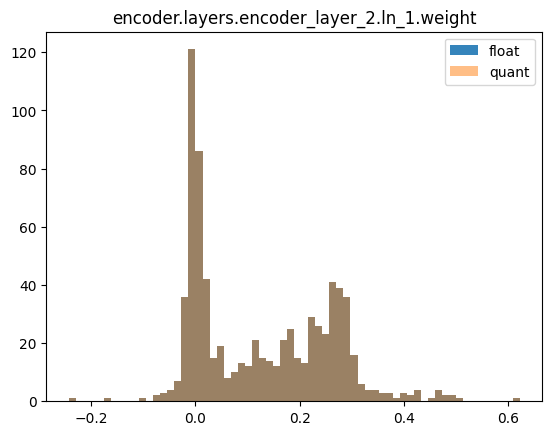

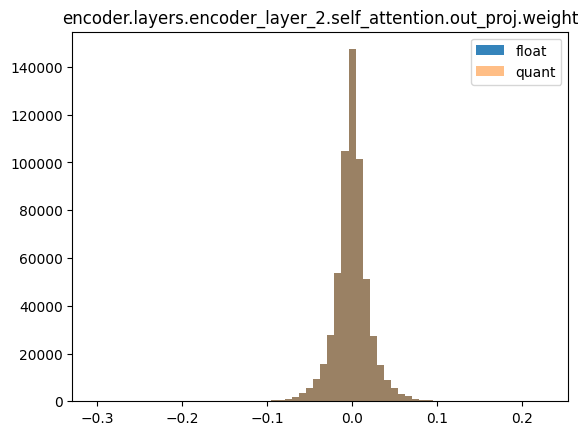

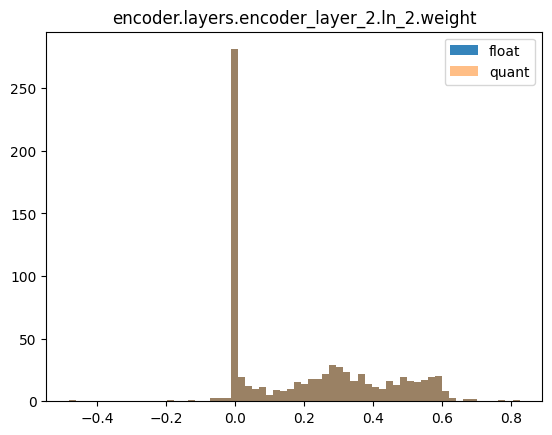

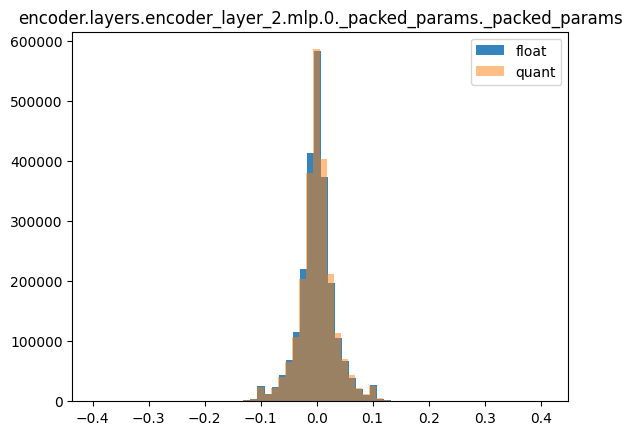

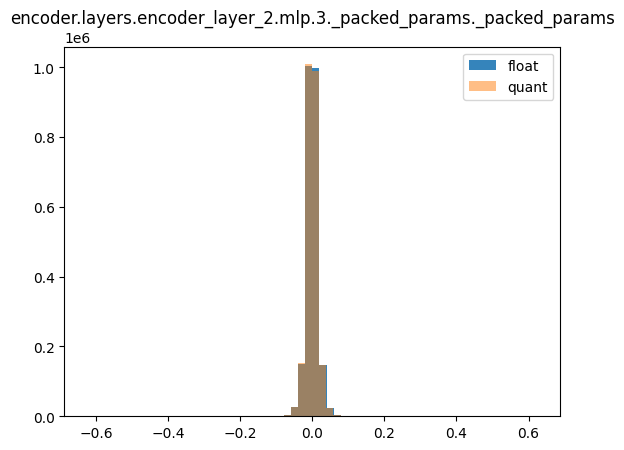

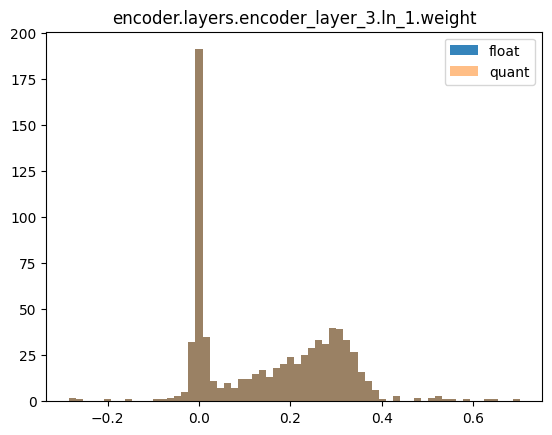

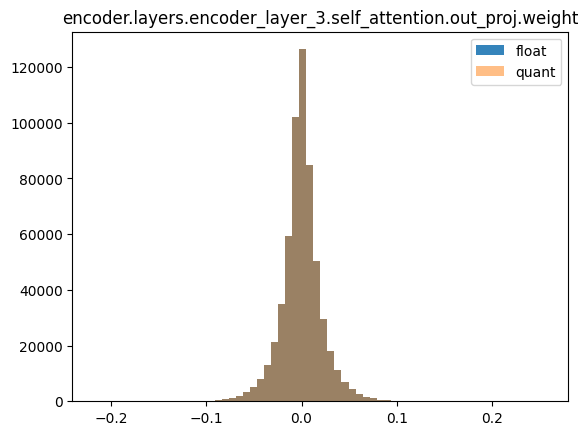

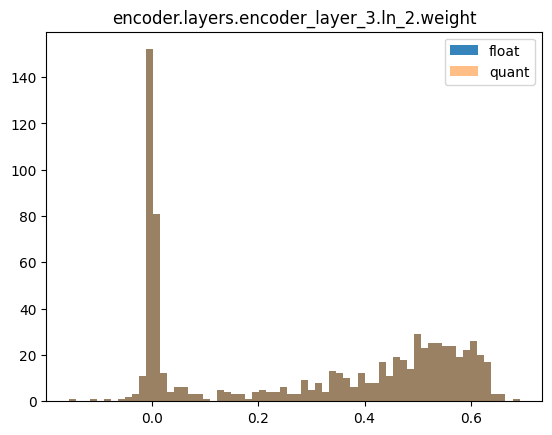

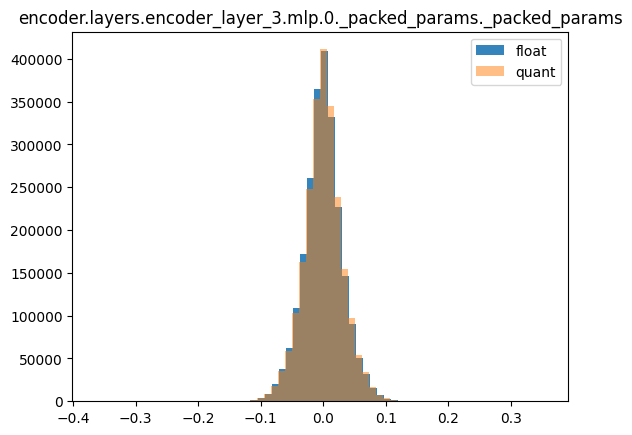

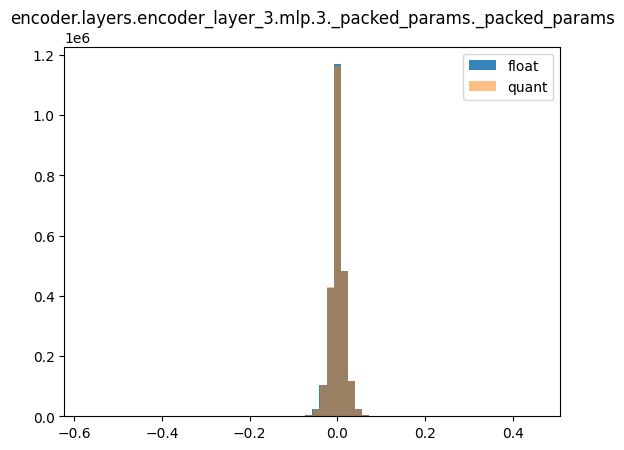

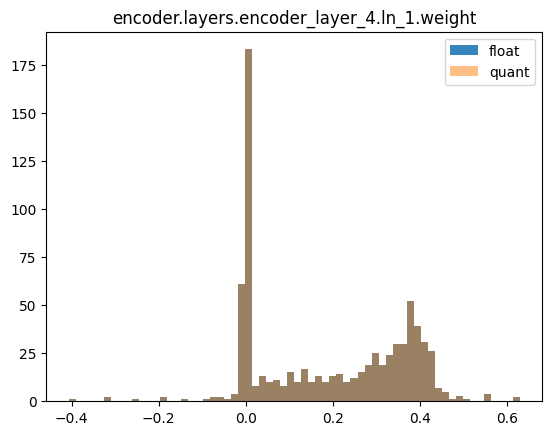

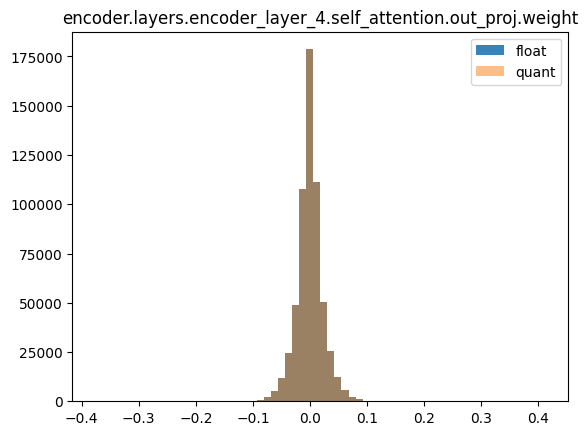

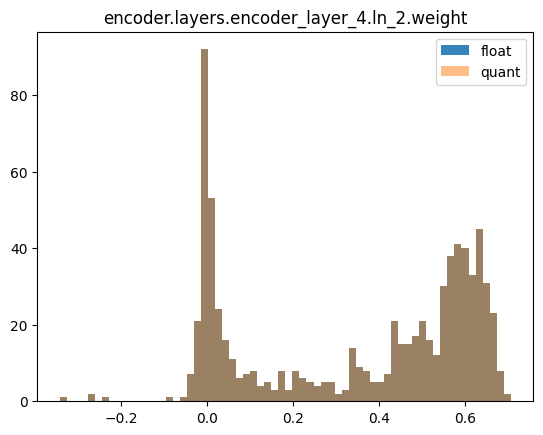

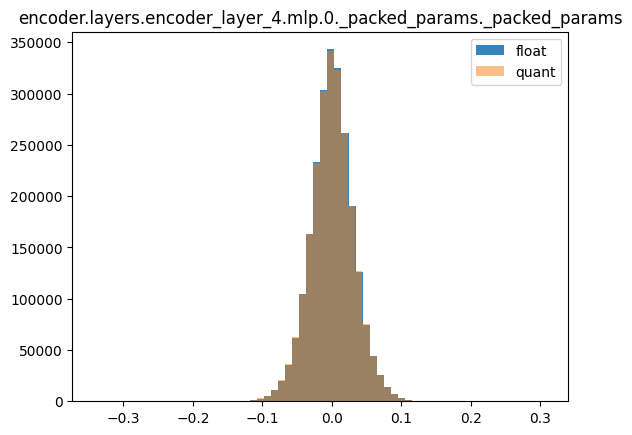

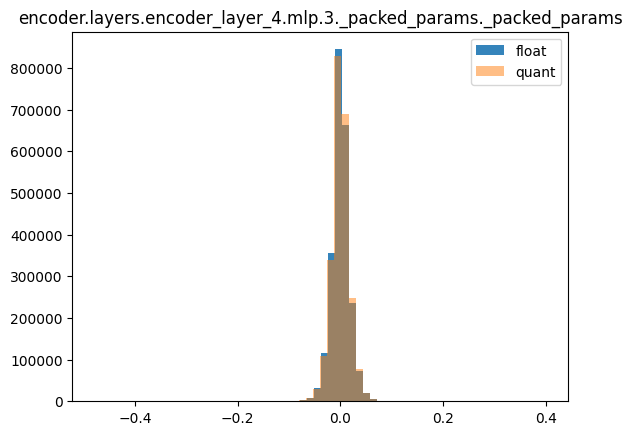

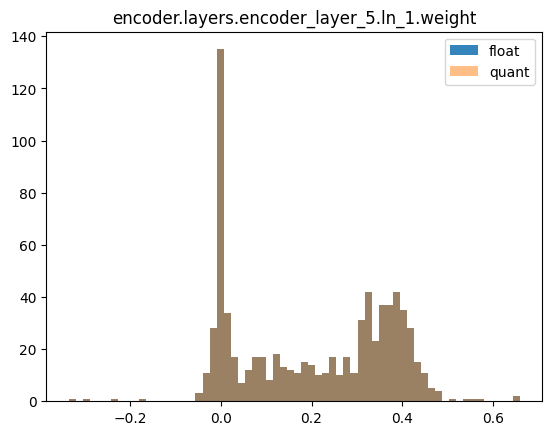

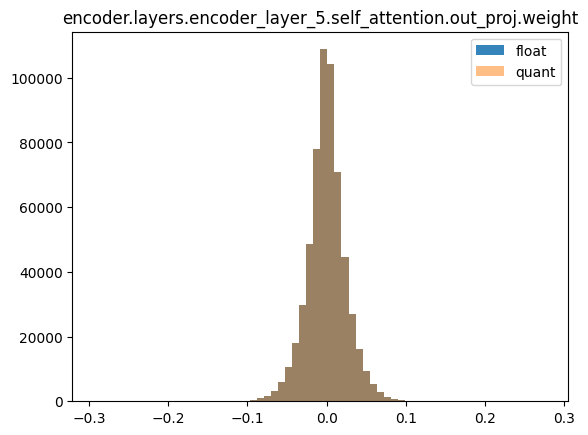

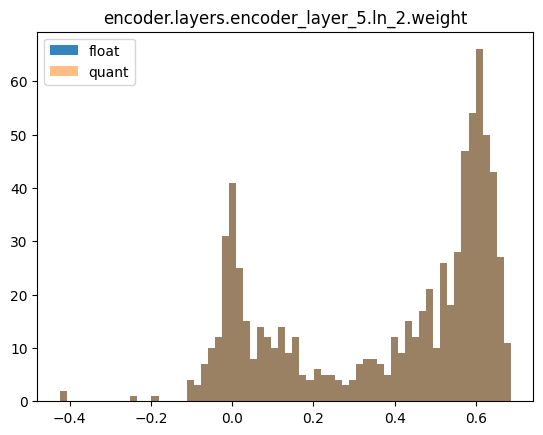

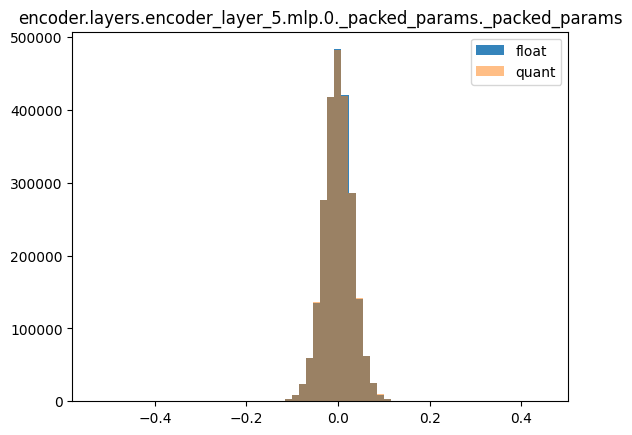

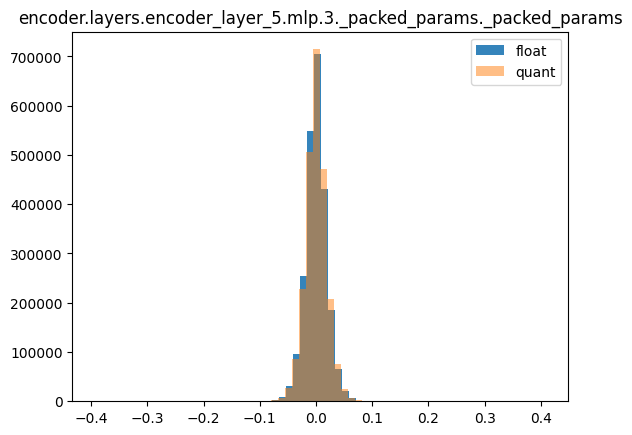

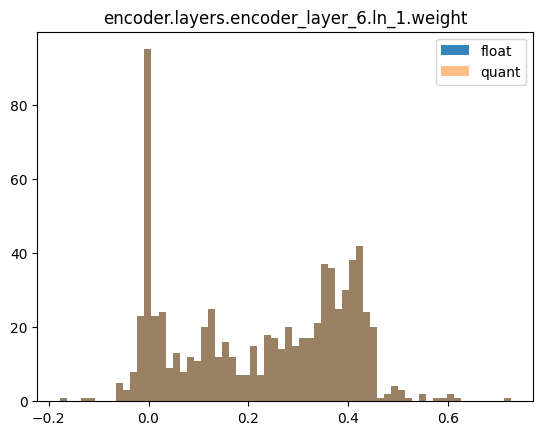

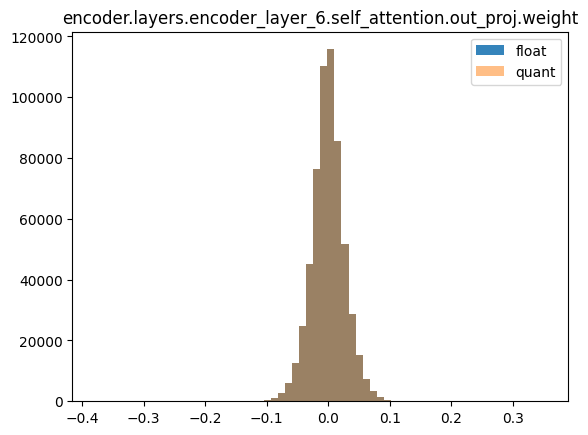

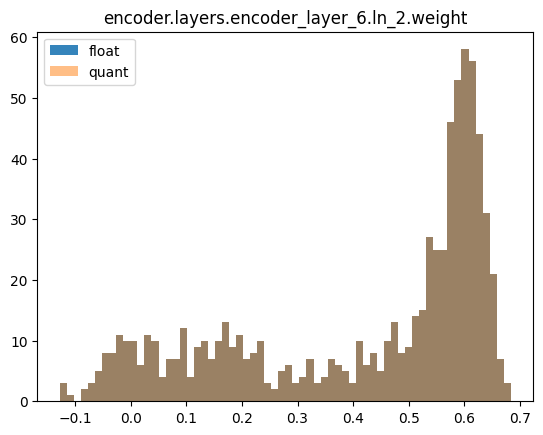

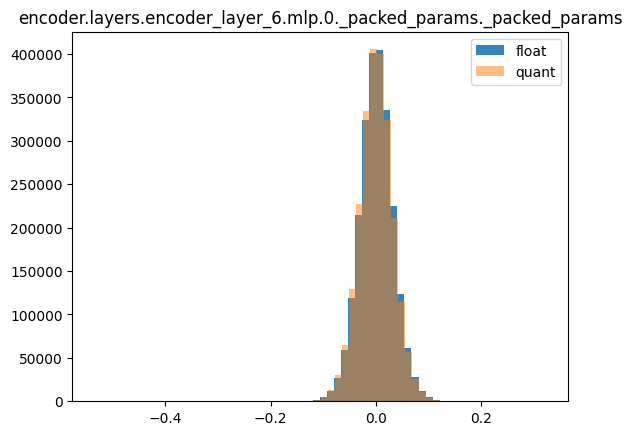

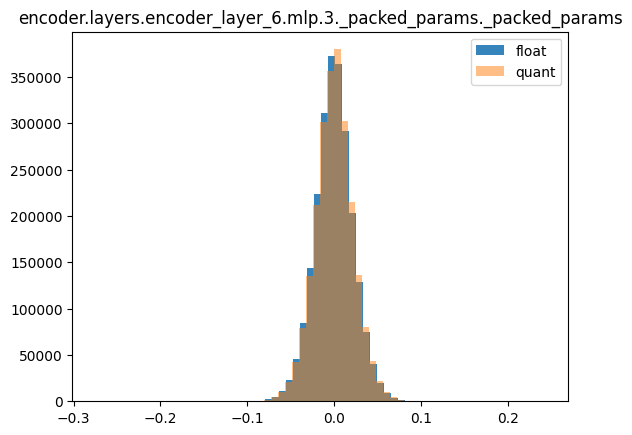

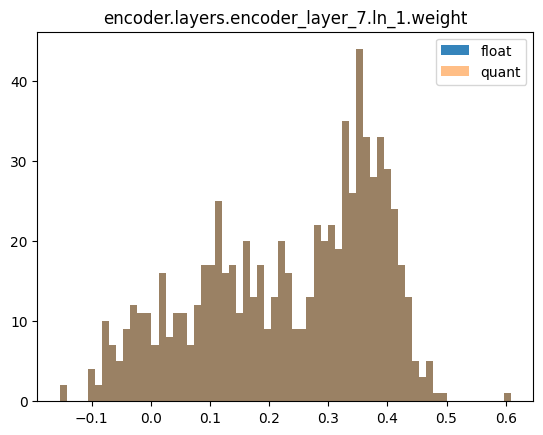

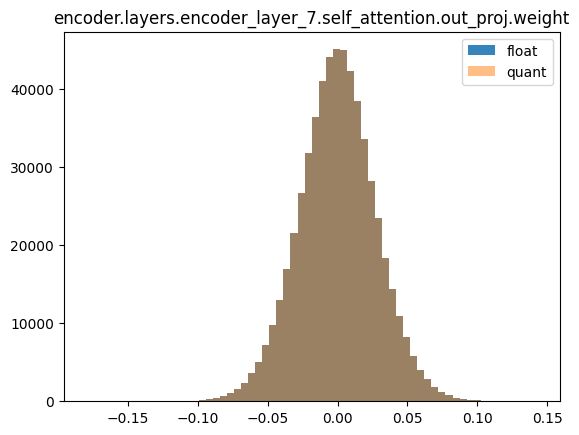

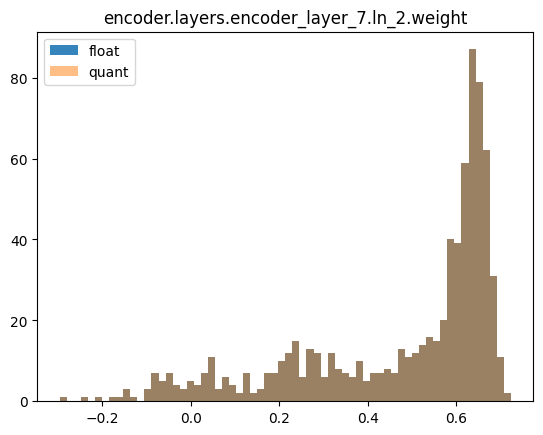

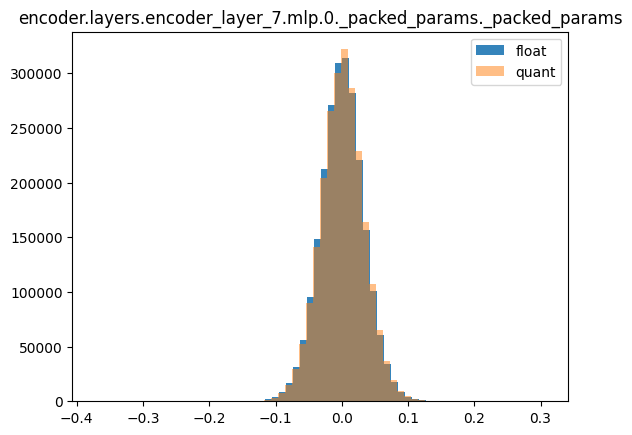

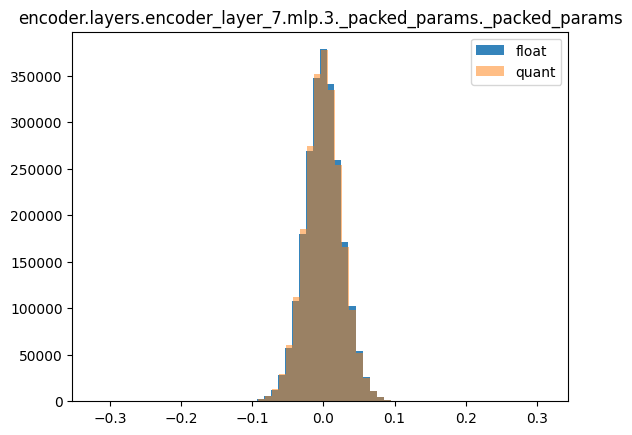

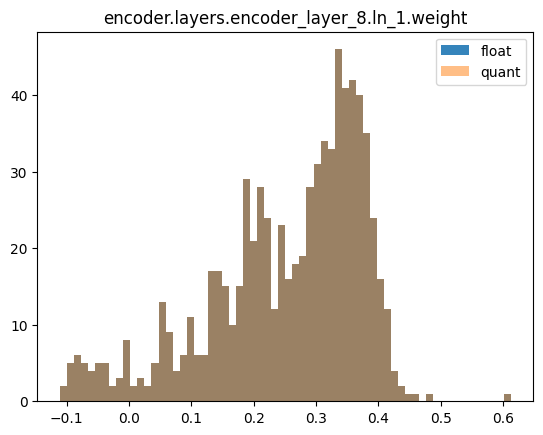

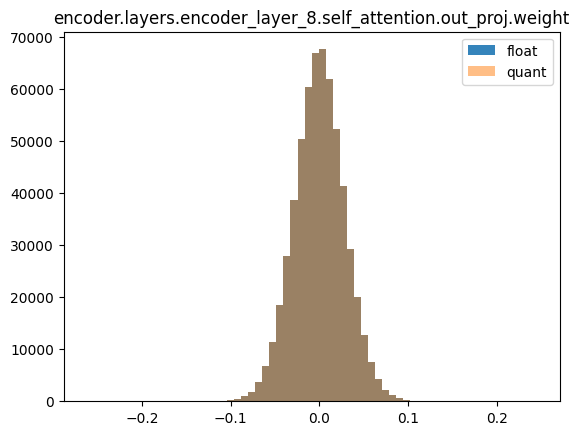

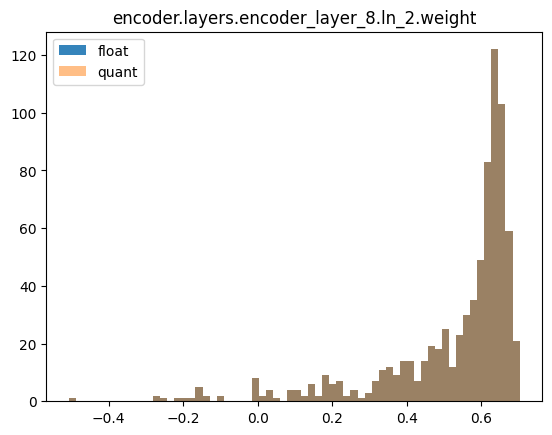

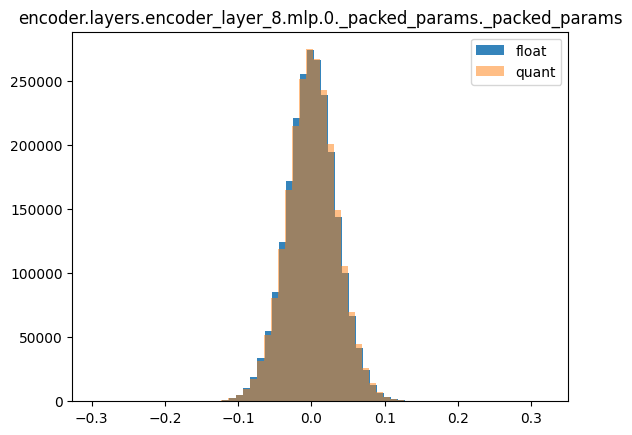

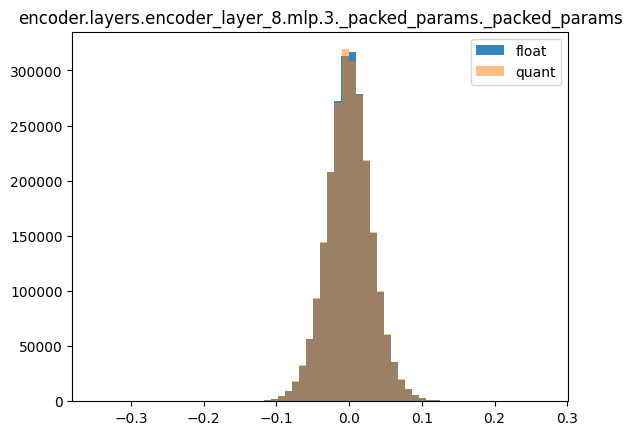

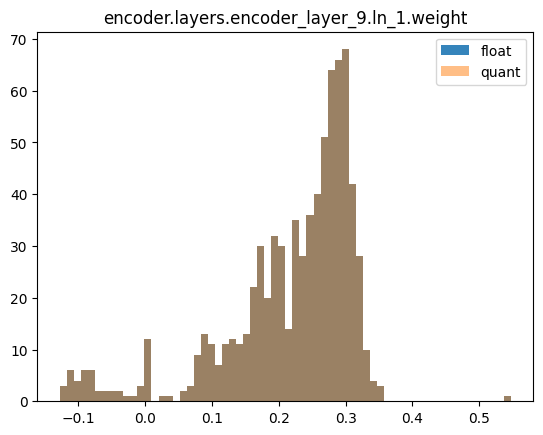

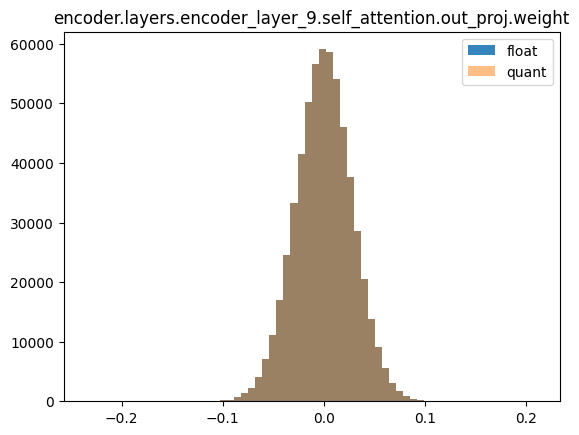

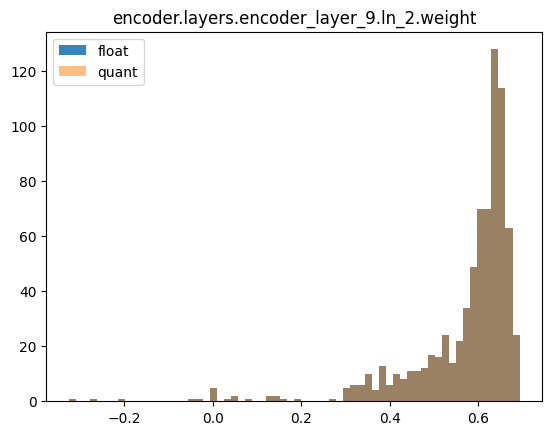

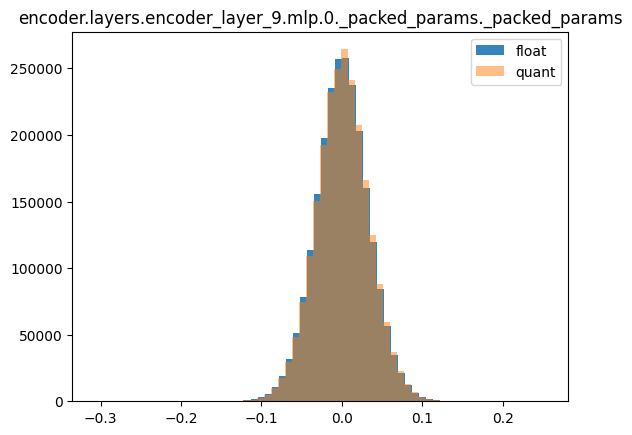

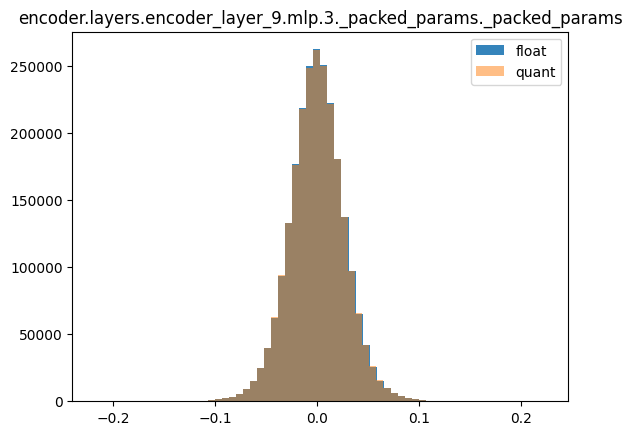

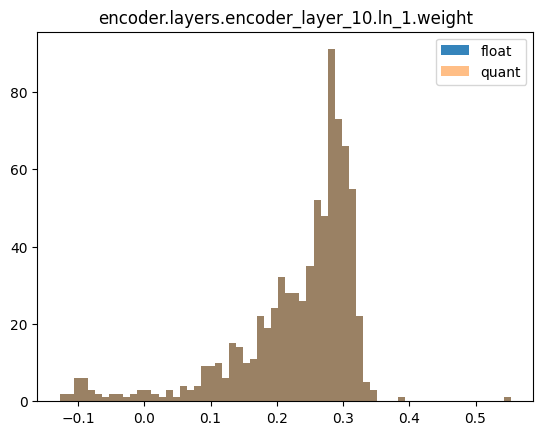

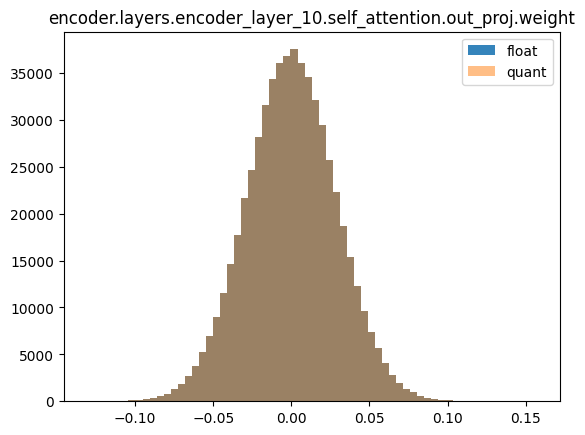

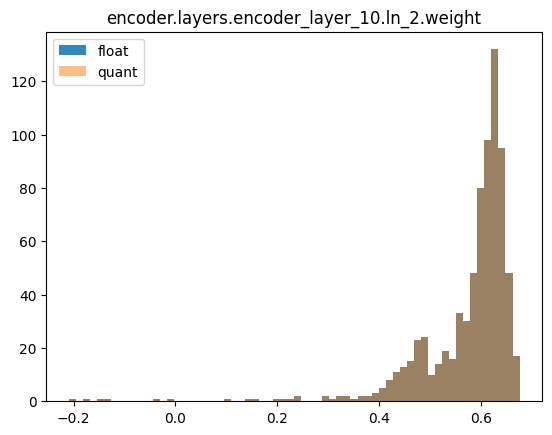

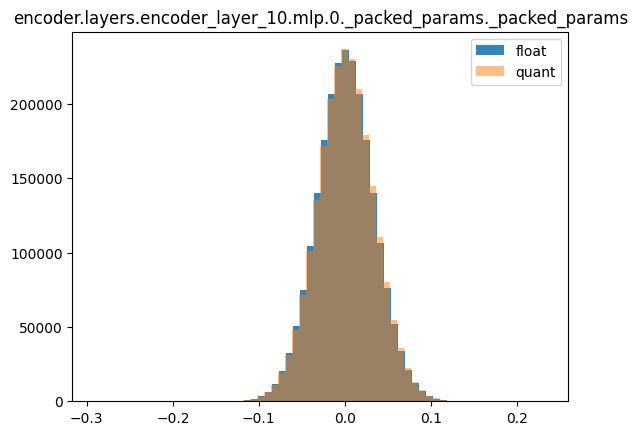

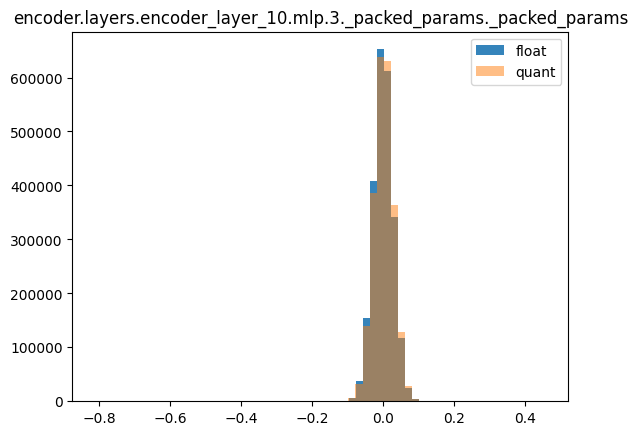

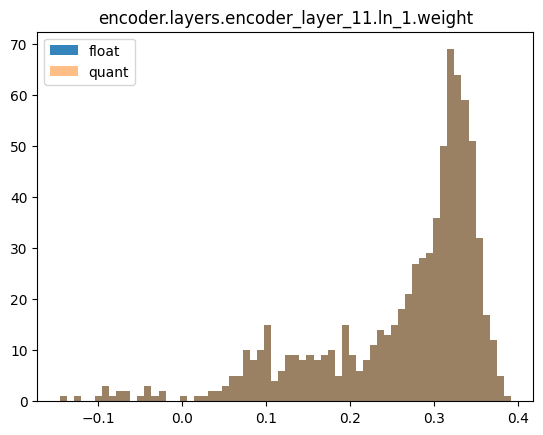

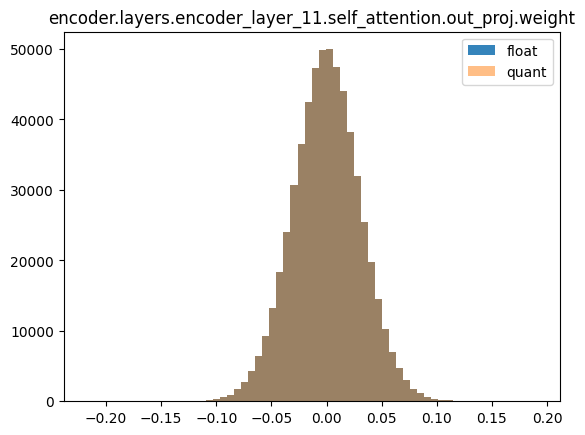

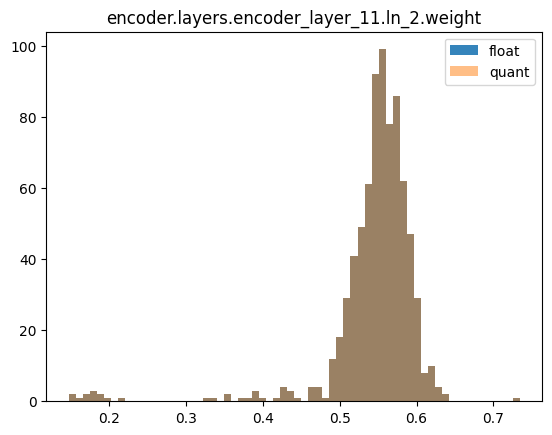

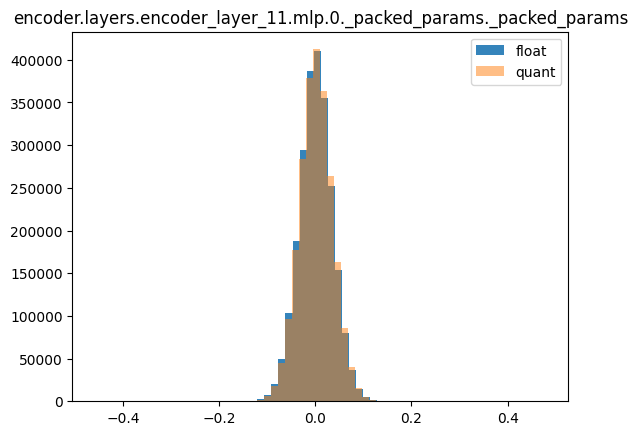

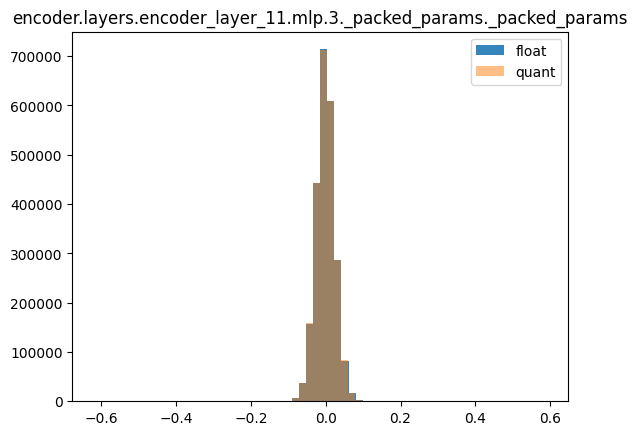

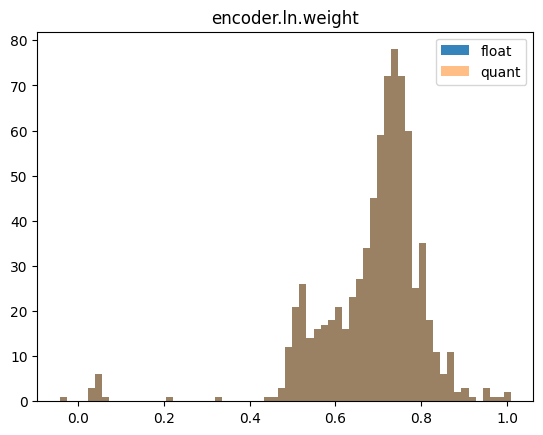

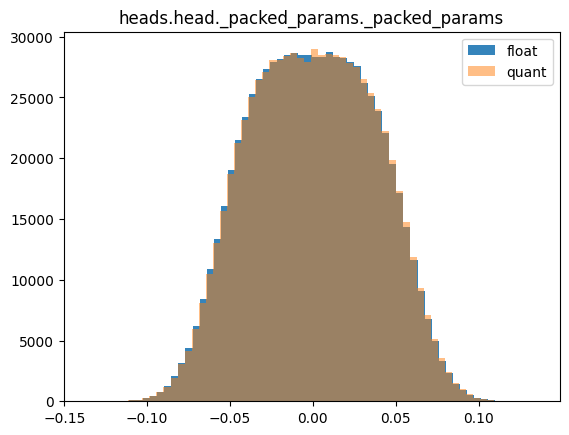

In [ ]:
for layer, d in tqdm(wt_compare_dict.items()):
    f = d['float']
    q = d['quantized']
    plt.hist(f.ravel(), bins=64, alpha=0.9, label='float')
    plt.hist(q.dequantize().ravel(), bins=64, alpha=0.5, label='quant')
    plt.title(layer)
    plt.legend()
    plt.show()